Theta method是local level的一个变种，但是在预测时间序列方面具有很强大的性能，它只需要在local level的状态变量表达式中加上一个常数项即可。

例如我们下面生成$e \sim N(\mu=0;\sigma_{e}^2=.8)$ , $u \sim N(\mu=0;\sigma_{u}^2=.1)$ 且$constant=.1$的序列：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

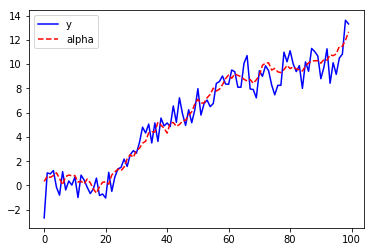

In [7]:
n=100
np.random.seed(572)
su=.1
se=.8
co=.1
e=np.sqrt(se)*np.random.randn(n)
u=np.sqrt(su)*np.random.randn(n)
y=np.zeros(n)
alpha=np.zeros(n)
y[0]=e[0]
alpha[0]=u[0]
for t in range(1,n):
  y[t]=alpha[t-1]+e[t]
  alpha[t]=alpha[t-1]+u[t]+co
plt.plot(y,'b',label="y")
plt.plot(alpha,'r--',label="alpha")
plt.legend()
plt.show()  

下面我们就用concentrated的极大似然函数来估计其中的参数：

In [3]:
a=np.zeros(n)
p=np.zeros(n)
a[0]=y[0]
p[0]=10000
k=np.zeros(n)
v=np.zeros(n)
def funTheta(mypa):
    q=abs(mypa[0])
    co=abs(mypa[1])
    z=1
    w=1
    likelihood=0
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*n*np.log(sigmae/n) 
    return likelihood
res=optimize.minimize(funTheta,[0.6,0.2])
print("极大似然估计所得结果：",res.x)
trueparam=[su/se,co]
print("真实参数：",trueparam)

极大似然估计所得结果： [ 0.2961434  0.1213051]
真实参数： [0.125, 0.1]


In [8]:
z=1
w=1
sigmae=0
q=res.x[0]
co=res.x[1]
for t in range(1,n):
    k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
    p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
    v[t]=y[t]-z*a[t-1]
    a[t]=co+w*a[t-1]+k[t]*v[t]
    sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
print("estimated sigmae=",sigmae/(n-1),';true sigmae=',se)
print("estimated sigmau=",q*(sigmae/(n-1)),';true sigmae=',su)

estimated sigmae= 0.652385591726 ;true sigmae= 0.8
estimated sigmau= 0.193199689205 ;true sigmae= 0.1


由于Theta method功能十分强大，因此下面我们自定义两个函数，分别生成Theta method序列并估计其参数：

In [13]:
def generateTheta(n,sigmae,sigmau,co):
    
    # 该函数生成Theta method序列，并输出y和alpha
    
    e=np.sqrt(sigmae)*np.random.randn(n)
    u=np.sqrt(sigmau)*np.random.randn(n)
    y=np.zeros(n)
    alpha=np.zeros(n)
    y[0]=e[0]
    alpha[0]=u[0]
    for t in range(1,n):
      y[t]=alpha[t-1]+e[t]
      alpha[t]=alpha[t-1]+u[t]+co
    return y,alpha

def EstimateTheta(y):
    n=len(y)
    a=np.zeros(n)
    p=np.zeros(n)
    k=np.zeros(n)
    v=np.zeros(n)
    def fu(mypa):        
        q=abs(mypa[0])
        co=abs(mypa[1])
        z=1
        w=1
        likelihood=0
        sigmae=0
        for t in range(1,n):
            k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
            p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
            v[t]=y[t]-z*a[t-1]
            a[t]=co+w*a[t-1]+k[t]*v[t]
            sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
            likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
        likelihood+=.5*n*np.log(sigmae/n) 
        return likelihood
    res=optimize.minimize(funTheta,[0.5,0.2])
    v[0]=0
    w=1
    z=1
    q=res.x[0]
    co=res.x[1]
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
    sigmae=sigmae/(n-1)
    sigmau=q*sigmae
    estimated_result=[sigmae,sigmau,co]
#     thelist=[a,v]
    return estimated_result

In [19]:
y,alpha=generateTheta(100,.6,.2,1)

In [20]:
np.random.seed(11)
result=EstimateTheta(y)
truepara=[0.6,0.2,1]
print("true parameter:",truepara,";estimated parameter:",result)

true parameter: [0.6, 0.2, 1] ;estimated parameter: [0.60136795890802119, 0.16567006125151662, 1.0054898152962248]


作图查看结果：

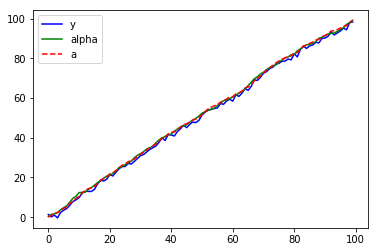

In [21]:
sigmae=result[0]
sigmau=result[1]
co=result[2]
a=np.zeros(n)
p=np.zeros(n)
k=np.zeros(n)
v=np.zeros(n)
for t in range(1,n):
    k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
    p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
    v[t]=y[t]-z*a[t-1]
    a[t]=co+w*a[t-1]+k[t]*v[t]
plt.plot(y,'b',label="y")
plt.plot(alpha,'g',label="alpha")
plt.plot(a,'r--',label='a')
plt.legend()
plt.show()  